# Bible code, but instead of KNN for neighborhood used mean num_crimes
-adding col2
-changing order in test and removing neighborhood_encoded from standardization


floor
1.0    1096.676873
2.0    1051.485876
3.0    1064.927848
4.0    1092.398710
5.0    1088.346247
6.0    1112.515152
7.0    1128.076730
8.0    1123.154044
9.0    1132.555012
Name: price, dtype: float64
Lower limit: 651.95
Upper limit: 1541.0499999999993
id               0.00
num_rooms        0.57
num_baths        2.00
square_meters    2.95
year_built       2.12
is_furnished     2.06
has_pool         1.95
neighborhood     2.06
num_crimes       2.00
has_ac           2.11
accepts_pets     1.94
price            0.00
floor            1.86
dtype: float64
        id  num_rooms  num_baths  square_meters  year_built is_furnished  \
274    352   -1.32823        NaN            NaN    0.227241         True   
397    504    1.34684        NaN            NaN    0.227241         True   
733    929   -0.43654        NaN            NaN    0.761478         True   
1882  2371    1.34684        NaN            NaN    0.518643         True   
2587  3257   -0.43654        NaN            NaN   -0.841232   

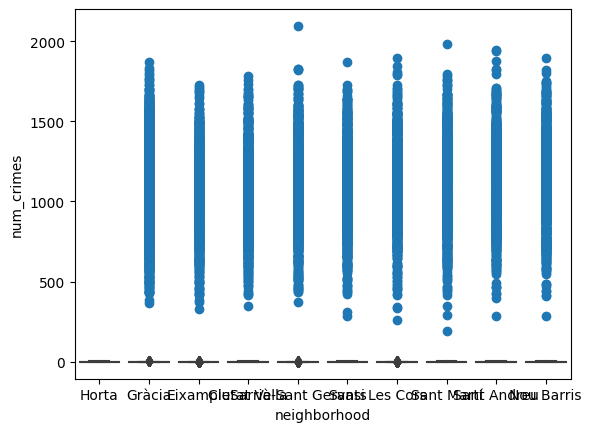

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
#import missingno as msno
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import numpy as np

# Filling data path
data_path = "./data//train.csv"

# reading CSV file
df = pd.read_csv(data_path)

# Sorting by the id and resetting the index
df=df.sort_values("id").reset_index(drop=True)

#################################################
# Dropping columns with high missing percentage #
#################################################

missing_percentage = df.isnull().sum()/len(df) * 100

# Dropping supermarkets number
df.drop('num_supermarkets', axis=1, inplace=True)

# Dropping orientation (argue saying that this is hardly inputer and has a 30% of missing data) 
df.drop('orientation', axis=1, inplace=True)


###########################
# Creating floor variable #
###########################

# Creating the floor variable
df[['floor', 'door_num']] = df['door'].str.split('-', n=1, expand=True)
df['floor'] = df['floor'].str[0]
df["floor"] = pd.to_numeric(df["floor"])

# The distribution of price to floor is interesting (the means are growing) - high floors (skyscrapers-cheaper)
plt.scatter(df['floor'], df['price'])
print(df.groupby('floor')['price'].mean())


#####################
# Handling outliers #
#####################

# Checking for outliers in price column
threshold=3.0
mean = np.mean(df['price'])
std = np.std(df['price'])
cutoff = threshold * std
lower_bound = mean - cutoff
upper_bound = mean + cutoff

# Calculating the number of records below and above lower and above bound value respectively
outliers = [x for x in df['price'] if (x >= upper_bound) | (x <= lower_bound)]

# Windsorizing price outliers
def winsorize(data, limits=(0.05, 0.05)):
    """
    Winsorize a dataset by replacing extreme values with less extreme values.

    Arguments:
    - data: 1-D array or list, the dataset to be winsorized.
    - limits: Tuple of two floats (lower, upper), representing the fraction of values to be replaced
              on each tail. Default is (0.05, 0.05), which replaces 5% of the values on each tail.

    Returns:
    - winsorized_data: 1-D array, the winsorized dataset.
    """
    # Copy the input data to avoid modifying the original array
    winsorized_data = np.copy(data)

    # Calculating the lower and upper limits for winsorization
    lower_limit = np.percentile(winsorized_data, limits[0] * 100)
    upper_limit = np.percentile(winsorized_data, 100 - limits[1] * 100)

    print('Lower limit:', lower_limit)
    print('Upper limit:', upper_limit)

    # Replacing values below the lower limit with the lower limit
    winsorized_data[winsorized_data < lower_limit] = lower_limit

    # Replacing values above the upper limit with the upper limit
    winsorized_data[winsorized_data > upper_limit] = upper_limit

    return winsorized_data

# Windsorizing the price variable
df['price'] = winsorize(df['price'], limits=(0.05, 0.05))

# Dropping door and door_num columns (justify: not influential)
df.drop('door', axis=1, inplace=True)
df.drop('door_num', axis=1, inplace=True)

# Replacing the outliers with NaN in the number of rooms (justify cutoff value: outliers are very high above 10)
df['num_rooms'] = df['num_rooms'].apply(lambda x: x if x<10 else np.nan)

# Replacing the values of square metres < 40 with NaN (change the cutoff value and see the results)
df.loc[df['square_meters'] < 40, 'square_meters'] = np.nan

# ANOTHER WAY: change the negative values to positive and then do the same (try and see results)
# df.loc[df['square_meters'] < 0, 'square_meters'] *= -1
# df.loc[df['square_meters'] < 40, 'square_meters'] = np.nan

###################
# Standardization #
###################

to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']

for i in to_standardize:
    df[i] = (df[i] - np.mean(df[i])) / np.std(df[i])


#########################
# Handling missing data #
#########################

# Missing values percentage
print(round((df.isnull().sum() / len(df) * 100), 2))

# Dropping NaNs from year built (justify: difficult to predict based on other variables, low value)
df = df.dropna(subset=['year_built'])

# Checking number of rows with multiple nulls (some examples)

print(df[(df['num_baths'].isnull()) & (df['square_meters'].isnull())]) #8#
print(df[(df['num_crimes'].isnull()) & (df['square_meters'].isnull())]) #4#
print(df[(df['floor'].isnull()) & (df['square_meters'].isnull())]) #2#

# dropping the rows that have multiple missing values
cols = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']
cols1 = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']
cols2= ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor']

for i in cols:
    for j in cols1:
        if i != j:
            df = df[(df[i].notnull()) | (df[j].notnull())]

#####################
# Imputing with KNN #
#####################

df_sub = df[cols2]
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_sub)
df_sub = pd.DataFrame(imputed_data, columns=df_sub.columns)
print(round((df_sub.isnull().sum() / len(df_sub) * 100), 2))

# Putting the imputed columns back in the original df
df = df.reset_index(drop=True)
#df = df.drop(cols, axis=1) !!!NEED TO DELETE!!!
df[cols2] = df_sub[cols2]
print(round((df.isnull().sum() / len(df) * 100), 2))

#######################################
# Imputing num_crimes from neighborhood
#######################################

mean_crimes_per_neighborhood = df.groupby('neighborhood')['num_crimes'].mean()

#function to fill missing values of num_crimes with the mean of the corresponding neighborhood
def fill_num_crimes(row):
    if pd.notna(row['num_crimes']):
        return row['num_crimes']
    neighborhood = row['neighborhood']
    if neighborhood in mean_crimes_per_neighborhood:
        return mean_crimes_per_neighborhood[neighborhood]
    else:
        return None
    
# apply to all missing values in 'num_crimes'
df['num_crimes'] = df.apply(fill_num_crimes, axis=1)

# filling NaNs of neighborhood based on their crime rate
def fill_nearest_neighborhood(row):
    if pd.isna(row['num_crimes']):
        return row['num_crimes']
    else:
        if pd.isna(row['neighborhood']):
            nearest_neighborhood = mean_crimes_per_neighborhood.index[
            np.abs(mean_crimes_per_neighborhood.values - row['num_crimes']).argmin()]
            return nearest_neighborhood
        else:
            return row['neighborhood']
        
df['neighborhood'] = df.apply(fill_nearest_neighborhood, axis=1)        

# dropping the remaining NaNs
df = df.dropna(axis= 0)

#################################
# Categorical Variable Encoding # 
#################################

# Using price to order the neighborhoods by mean price
sns.boxplot(data=df, x='neighborhood', y='num_crimes')

# Encoding neighborhood by mean price of house
#neighb_mean_price = df.groupby('neighborhood')['price'].mean()
#df['neighborhood_price_encoded'] = df['neighborhood'].map(neighb_mean_price)

neighb_mean_crime = df.groupby('neighborhood')['num_crimes'].mean()
df['neighborhood_crime_encoded'] = df['neighborhood'].map(neighb_mean_crime)

########################
# Feature Engiineering # 
########################

# **NOT SURE IF SHOULD BE DONE BEFORE STANDARDIZING**

# # Floor looks to have a cubed distribution, so cubing the floor variable 8the coefficient grows by a lot (1.52 to 6.36) but the score slightly decreases)
# df['floor'] = df['floor'] ** 3

#IDEAS:
# Rooms per square meter
# Bathrooms per square meter


####################
# Linear Modelling #
####################

# Running simple linear model without feature scaling, using  num_crimes and square_meters as predictors
y_train = df['price']
x_train = df[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neighborhood_crime_encoded', 'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets']]

model = LinearRegression()
model.fit(x_train, y_train)

# Model res
# model.coef_
# model.intercept_
# model.score(x_train, y_train)


###########
# Testing #
###########


# Test data import
data_path_test = "./data//test.csv"
df_test = pd.read_csv(data_path_test)
df_test=df_test.sort_values("id").reset_index(drop=True)

# Dropping columns with high missing percentage
df_test.drop('num_supermarkets', axis=1, inplace=True)
df_test.drop('orientation', axis=1, inplace=True)

# Creating floor variable
df_test[['floor', 'door_num']] = df_test['door'].str.split('-', n=1, expand=True)
df_test['floor'] = df_test['floor'].str[0]
df_test["floor"] = pd.to_numeric(df_test["floor"])

# Dropping door and door_num columns
df_test.drop('door', axis=1, inplace=True)
df_test.drop('door_num', axis=1, inplace=True)

# Turning to nan sq.mt and num_rooms
df_test['num_rooms'] = df_test['num_rooms'].apply(lambda x: x if x<10 else np.nan)
df_test.loc[df_test['square_meters'] < 40, 'square_meters'] = np.nan


# Standardizing
to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']
for i in to_standardize:
    df_test[i] = (df_test[i] - np.mean(df_test[i])) / np.std(df_test[i])

#filling neighborhood and num_crimes
df_test['num_crimes'] = df_test.apply(fill_num_crimes, axis=1)   
df_test['neighborhood'] = df_test.apply(fill_nearest_neighborhood, axis=1)

# Neighborhood encoding and dropping categorical variable
neighb_mean_crime = df_test.groupby('neighborhood')['num_crimes'].mean()
df_test['neighborhood_crime_encoded'] = df_test['neighborhood'].map(neighb_mean_crime)
df_test.drop('neighborhood', axis=1, inplace=True)

# KNN 
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_test)
df_test = pd.DataFrame(imputed_data, columns=df_test.columns)
print(round((df_test.isnull().sum() / len(df_test) * 100), 2))

# Prediction
x_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neighborhood_crime_encoded', 'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets']]
y_pred = model.predict(x_test)

df_pred = pd.DataFrame()
df_pred['id'] = df_test['id']
df_pred['price'] = y_pred

df_pred.to_csv('C:/Users/vanes/Desktop/BSE/prediction_filling_na_num_crimes_with_neighborhood_viceversa.csv', index=False)

############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################


# Bible code, but not using all variables
-first looking which variables need to be included in model


floor
1.0    1096.676873
2.0    1051.485876
3.0    1064.927848
4.0    1092.398710
5.0    1088.346247
6.0    1112.515152
7.0    1128.076730
8.0    1123.154044
9.0    1132.555012
Name: price, dtype: float64
Lower limit: 651.95
Upper limit: 1541.0499999999993
id               0.00
num_rooms        0.57
num_baths        2.00
square_meters    2.95
year_built       2.12
is_furnished     2.06
has_pool         1.95
neighborhood     2.06
num_crimes       2.00
has_ac           2.11
accepts_pets     1.94
price            0.00
floor            1.86
dtype: float64
        id  num_rooms  num_baths  square_meters  year_built is_furnished  \
274    352   -1.32823        NaN            NaN    0.227241         True   
397    504    1.34684        NaN            NaN    0.227241         True   
733    929   -0.43654        NaN            NaN    0.761478         True   
1882  2371    1.34684        NaN            NaN    0.518643         True   
2587  3257   -0.43654        NaN            NaN   -0.841232   

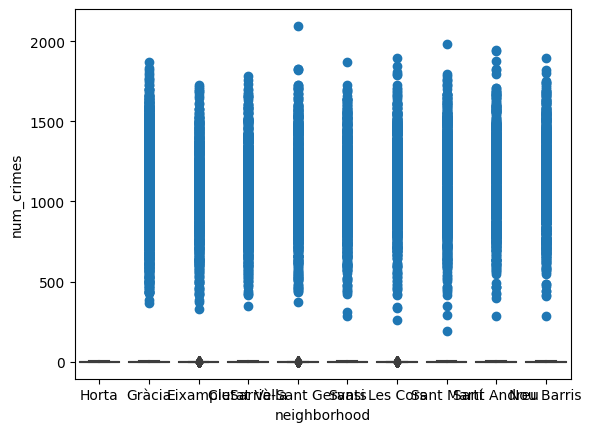

In [50]:
#### just code to modify the test data
import pandas as pd
import matplotlib.pyplot as plt
#import missingno as msno
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import numpy as np

# Filling data path
data_path = "./data//train.csv"

# reading CSV file
df = pd.read_csv(data_path)

# Sorting by the id and resetting the index
df=df.sort_values("id").reset_index(drop=True)

#################################################
# Dropping columns with high missing percentage #
#################################################

missing_percentage = df.isnull().sum()/len(df) * 100

# Dropping supermarkets number
df.drop('num_supermarkets', axis=1, inplace=True)

# Dropping orientation (argue saying that this is hardly inputer and has a 30% of missing data) 
df.drop('orientation', axis=1, inplace=True)


###########################
# Creating floor variable #
###########################

# Creating the floor variable
df[['floor', 'door_num']] = df['door'].str.split('-', n=1, expand=True)
df['floor'] = df['floor'].str[0]
df["floor"] = pd.to_numeric(df["floor"])

# The distribution of price to floor is interesting (the means are growing) - high floors (skyscrapers-cheaper)
plt.scatter(df['floor'], df['price'])
print(df.groupby('floor')['price'].mean())


#####################
# Handling outliers #
#####################

# Checking for outliers in price column
threshold=3.0
mean = np.mean(df['price'])
std = np.std(df['price'])
cutoff = threshold * std
lower_bound = mean - cutoff
upper_bound = mean + cutoff

# Calculating the number of records below and above lower and above bound value respectively
outliers = [x for x in df['price'] if (x >= upper_bound) | (x <= lower_bound)]

# Windsorizing price outliers
def winsorize(data, limits=(0.05, 0.05)):
    """
    Winsorize a dataset by replacing extreme values with less extreme values.

    Arguments:
    - data: 1-D array or list, the dataset to be winsorized.
    - limits: Tuple of two floats (lower, upper), representing the fraction of values to be replaced
              on each tail. Default is (0.05, 0.05), which replaces 5% of the values on each tail.

    Returns:
    - winsorized_data: 1-D array, the winsorized dataset.
    """
    # Copy the input data to avoid modifying the original array
    winsorized_data = np.copy(data)

    # Calculating the lower and upper limits for winsorization
    lower_limit = np.percentile(winsorized_data, limits[0] * 100)
    upper_limit = np.percentile(winsorized_data, 100 - limits[1] * 100)

    print('Lower limit:', lower_limit)
    print('Upper limit:', upper_limit)

    # Replacing values below the lower limit with the lower limit
    winsorized_data[winsorized_data < lower_limit] = lower_limit

    # Replacing values above the upper limit with the upper limit
    winsorized_data[winsorized_data > upper_limit] = upper_limit

    return winsorized_data

# Windsorizing the price variable
df['price'] = winsorize(df['price'], limits=(0.05, 0.05))

# Dropping door and door_num columns (justify: not influential)
df.drop('door', axis=1, inplace=True)
df.drop('door_num', axis=1, inplace=True)

# Replacing the outliers with NaN in the number of rooms (justify cutoff value: outliers are very high above 10)
df['num_rooms'] = df['num_rooms'].apply(lambda x: x if x<10 else np.nan)

# Replacing the values of square metres < 40 with NaN (change the cutoff value and see the results)
df.loc[df['square_meters'] < 40, 'square_meters'] = np.nan

# ANOTHER WAY: change the negative values to positive and then do the same (try and see results)
# df.loc[df['square_meters'] < 0, 'square_meters'] *= -1
# df.loc[df['square_meters'] < 40, 'square_meters'] = np.nan

###################
# Standardization #
###################

to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']

for i in to_standardize:
    df[i] = (df[i] - np.mean(df[i])) / np.std(df[i])


#########################
# Handling missing data #
#########################

# Missing values percentage
print(round((df.isnull().sum() / len(df) * 100), 2))

# Dropping NaNs from year built (justify: difficult to predict based on other variables, low value)
df = df.dropna(subset=['year_built'])

# Checking number of rows with multiple nulls (some examples)

print(df[(df['num_baths'].isnull()) & (df['square_meters'].isnull())]) #8#
print(df[(df['num_crimes'].isnull()) & (df['square_meters'].isnull())]) #4#
print(df[(df['floor'].isnull()) & (df['square_meters'].isnull())]) #2#

# dropping the rows that have multiple missing values
cols = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']
cols1 = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']

for i in cols:
    for j in cols1:
        if i != j:
            df = df[(df[i].notnull()) | (df[j].notnull())]

#####################
# Imputing with KNN #
#####################

df_sub = df[cols]
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_sub)
df_sub = pd.DataFrame(imputed_data, columns=df_sub.columns)
print(round((df_sub.isnull().sum() / len(df_sub) * 100), 2))

# Putting the imputed columns back in the original df
df = df.reset_index(drop=True)
df = df.drop(cols, axis=1)
df[cols] = df_sub[cols]
print(round((df.isnull().sum() / len(df) * 100), 2))

# dropping the remaining NaNs
df = df.dropna(axis= 0)

#################################
# Categorical Variable Encoding # 
#################################

# Using price to order the neighborhoods by mean price
sns.boxplot(data=df, x='neighborhood', y='num_crimes')

# Encoding neighborhood by mean price of house
#neighb_mean_price = df.groupby('neighborhood')['price'].mean()
#df['neighborhood_price_encoded'] = df['neighborhood'].map(neighb_mean_price)

neighb_mean_crime = df.groupby('neighborhood')['num_crimes'].mean()
df['neighborhood_crime_encoded'] = df['neighborhood'].map(neighb_mean_crime)
df.drop('neighborhood', axis= 1, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

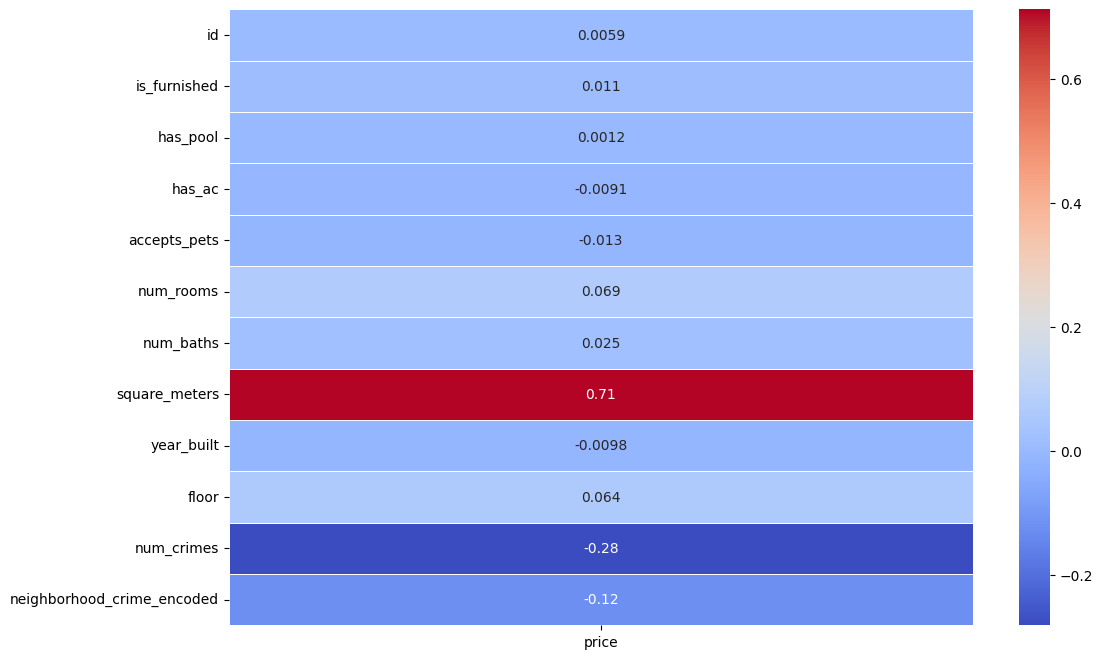

In [51]:
# Calculate the correlation matrix
correlation_matrix = df.corr(method='pearson')

# Calculate the correlation of all columns with respect to the 'price' column
price_correlation = correlation_matrix['price']

# The 'price' column will also have a correlation of 1 with itself. You can remove it if needed.
price_correlation = price_correlation.drop('price')

plt.figure(figsize=(12, 8))
sns.heatmap(price_correlation.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show

## try model with only 'square_meters', 'num_crimes', 'neighborhood_crime_encoded', 'num_rooms', 'floor'

<function matplotlib.pyplot.show(close=None, block=None)>

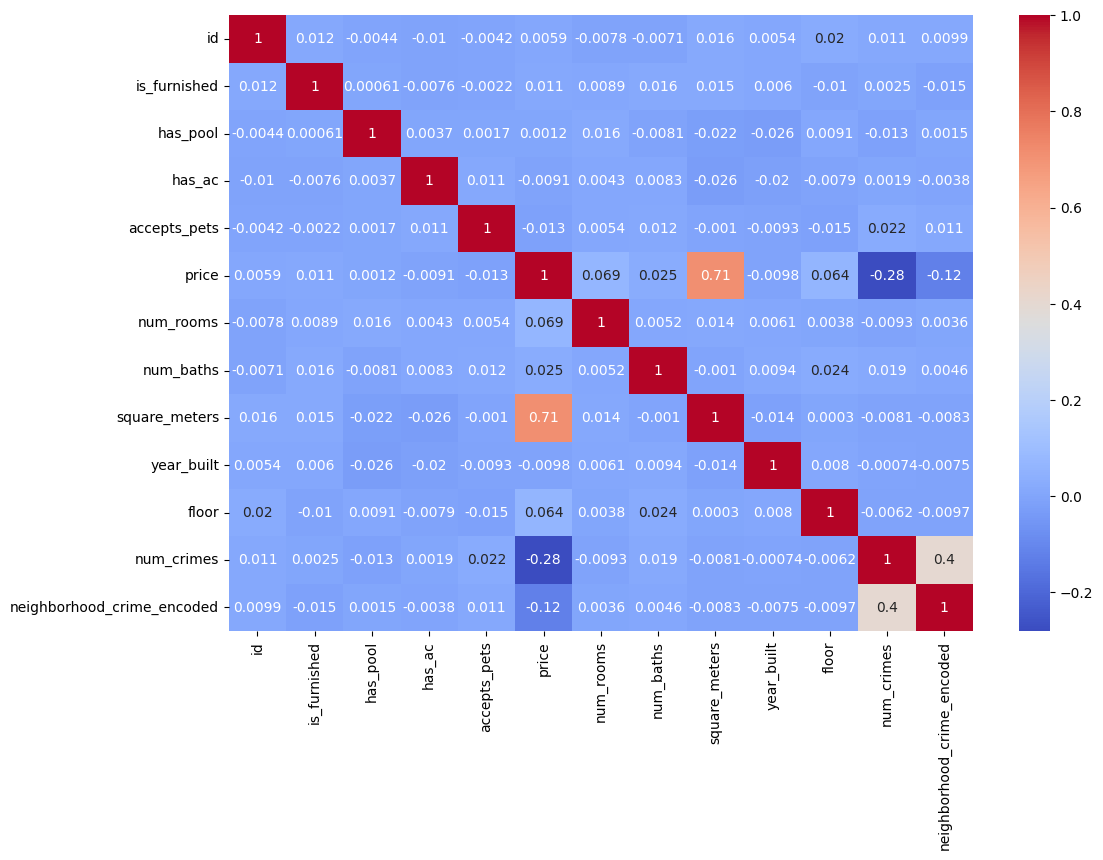

In [47]:
#looking for collineariry
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show

In [55]:
# Test data import
data_path_test = "./data//test.csv"
df_test = pd.read_csv(data_path_test)
df_test=df_test.sort_values("id").reset_index(drop=True)

# Dropping columns with high missing percentage
df_test.drop('num_supermarkets', axis=1, inplace=True)
df_test.drop('orientation', axis=1, inplace=True)

# Creating floor variable
df_test[['floor', 'door_num']] = df_test['door'].str.split('-', n=1, expand=True)
df_test['floor'] = df_test['floor'].str[0]
df_test["floor"] = pd.to_numeric(df_test["floor"])

# Dropping door and door_num columns
df_test.drop('door', axis=1, inplace=True)
df_test.drop('door_num', axis=1, inplace=True)

# Turning to nan sq.mt and num_rooms
df_test['num_rooms'] = df_test['num_rooms'].apply(lambda x: x if x<10 else np.nan)
df_test.loc[df_test['square_meters'] < 40, 'square_meters'] = np.nan

# Neighborhood encoding and dropping categorical variable
neighb_mean_crime = df_test.groupby('neighborhood')['num_crimes'].mean()
df_test['neighborhood_crime_encoded'] = df_test['neighborhood'].map(neighb_mean_crime)
df_test.drop('neighborhood', axis=1, inplace=True)

# Standardizing
to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neighborhood_crime_encoded']
for i in to_standardize:
    df_test[i] = (df_test[i] - np.mean(df_test[i])) / np.std(df_test[i])

# KNN 
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_test)
df_test = pd.DataFrame(imputed_data, columns=df_test.columns)
print(round((df_test.isnull().sum() / len(df_test) * 100), 2))

# Prediction
x_test = df_test[['square_meters', 'num_crimes', 'neighborhood_crime_encoded', 'num_rooms', 'floor']]
y_pred = model.predict(x_test)

df_pred = pd.DataFrame()
df_pred['id'] = df_test['id']
df_pred['price'] = y_pred

id                            0.0
num_rooms                     0.0
num_baths                     0.0
square_meters                 0.0
year_built                    0.0
is_furnished                  0.0
has_pool                      0.0
num_crimes                    0.0
has_ac                        0.0
accepts_pets                  0.0
floor                         0.0
neighborhood_crime_encoded    0.0
dtype: float64


floor
1.0    1096.676873
2.0    1051.485876
3.0    1064.927848
4.0    1092.398710
5.0    1088.346247
6.0    1112.515152
7.0    1128.076730
8.0    1123.154044
9.0    1132.555012
Name: price, dtype: float64
Lower limit: 651.95
Upper limit: 1541.0499999999993
id               0.00
num_rooms        0.57
num_baths        2.00
square_meters    2.95
year_built       2.12
is_furnished     2.06
has_pool         1.95
neighborhood     2.06
num_crimes       2.00
has_ac           2.11
accepts_pets     1.94
price            0.00
floor            1.86
dtype: float64
        id  num_rooms  num_baths  square_meters  year_built is_furnished  \
274    352   -1.32823        NaN            NaN    0.227241         True   
397    504    1.34684        NaN            NaN    0.227241         True   
733    929   -0.43654        NaN            NaN    0.761478         True   
1882  2371    1.34684        NaN            NaN    0.518643         True   
2587  3257   -0.43654        NaN            NaN   -0.841232   

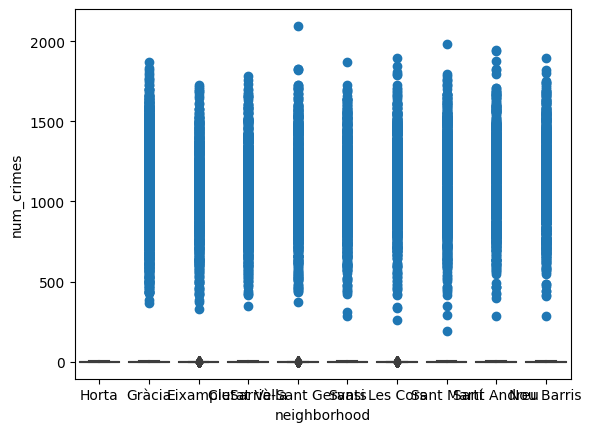

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
#import missingno as msno
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
import numpy as np

# Filling data path
data_path = "./data//train.csv"

# reading CSV file
df = pd.read_csv(data_path)

# Sorting by the id and resetting the index
df=df.sort_values("id").reset_index(drop=True)

#################################################
# Dropping columns with high missing percentage #
#################################################

missing_percentage = df.isnull().sum()/len(df) * 100

# Dropping supermarkets number
df.drop('num_supermarkets', axis=1, inplace=True)

# Dropping orientation (argue saying that this is hardly inputer and has a 30% of missing data) 
df.drop('orientation', axis=1, inplace=True)


###########################
# Creating floor variable #
###########################

# Creating the floor variable
df[['floor', 'door_num']] = df['door'].str.split('-', n=1, expand=True)
df['floor'] = df['floor'].str[0]
df["floor"] = pd.to_numeric(df["floor"])

# The distribution of price to floor is interesting (the means are growing) - high floors (skyscrapers-cheaper)
plt.scatter(df['floor'], df['price'])
print(df.groupby('floor')['price'].mean())


#####################
# Handling outliers #
#####################

# Checking for outliers in price column
threshold=3.0
mean = np.mean(df['price'])
std = np.std(df['price'])
cutoff = threshold * std
lower_bound = mean - cutoff
upper_bound = mean + cutoff

# Calculating the number of records below and above lower and above bound value respectively
outliers = [x for x in df['price'] if (x >= upper_bound) | (x <= lower_bound)]

# Windsorizing price outliers
def winsorize(data, limits=(0.05, 0.05)):
    """
    Winsorize a dataset by replacing extreme values with less extreme values.

    Arguments:
    - data: 1-D array or list, the dataset to be winsorized.
    - limits: Tuple of two floats (lower, upper), representing the fraction of values to be replaced
              on each tail. Default is (0.05, 0.05), which replaces 5% of the values on each tail.

    Returns:
    - winsorized_data: 1-D array, the winsorized dataset.
    """
    # Copy the input data to avoid modifying the original array
    winsorized_data = np.copy(data)

    # Calculating the lower and upper limits for winsorization
    lower_limit = np.percentile(winsorized_data, limits[0] * 100)
    upper_limit = np.percentile(winsorized_data, 100 - limits[1] * 100)

    print('Lower limit:', lower_limit)
    print('Upper limit:', upper_limit)

    # Replacing values below the lower limit with the lower limit
    winsorized_data[winsorized_data < lower_limit] = lower_limit

    # Replacing values above the upper limit with the upper limit
    winsorized_data[winsorized_data > upper_limit] = upper_limit

    return winsorized_data

# Windsorizing the price variable
df['price'] = winsorize(df['price'], limits=(0.05, 0.05))

# Dropping door and door_num columns (justify: not influential)
df.drop('door', axis=1, inplace=True)
df.drop('door_num', axis=1, inplace=True)

# Replacing the outliers with NaN in the number of rooms (justify cutoff value: outliers are very high above 10)
df['num_rooms'] = df['num_rooms'].apply(lambda x: x if x<10 else np.nan)

# Replacing the values of square metres < 40 with NaN (change the cutoff value and see the results)
df.loc[df['square_meters'] < 40, 'square_meters'] = np.nan

# ANOTHER WAY: change the negative values to positive and then do the same (try and see results)
# df.loc[df['square_meters'] < 0, 'square_meters'] *= -1
# df.loc[df['square_meters'] < 40, 'square_meters'] = np.nan

###################
# Standardization #
###################

to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']

for i in to_standardize:
    df[i] = (df[i] - np.mean(df[i])) / np.std(df[i])


#########################
# Handling missing data #
#########################

# Missing values percentage
print(round((df.isnull().sum() / len(df) * 100), 2))

# Dropping NaNs from year built (justify: difficult to predict based on other variables, low value)
df = df.dropna(subset=['year_built'])

# Checking number of rows with multiple nulls (some examples)

print(df[(df['num_baths'].isnull()) & (df['square_meters'].isnull())]) #8#
print(df[(df['num_crimes'].isnull()) & (df['square_meters'].isnull())]) #4#
print(df[(df['floor'].isnull()) & (df['square_meters'].isnull())]) #2#

# dropping the rows that have multiple missing values
cols = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']
cols1 = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes']

for i in cols:
    for j in cols1:
        if i != j:
            df = df[(df[i].notnull()) | (df[j].notnull())]

#####################
# Imputing with KNN #
#####################

df_sub = df[cols]
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_sub)
df_sub = pd.DataFrame(imputed_data, columns=df_sub.columns)
print(round((df_sub.isnull().sum() / len(df_sub) * 100), 2))

# Putting the imputed columns back in the original df
df = df.reset_index(drop=True)
df = df.drop(cols, axis=1)
df[cols] = df_sub[cols]
print(round((df.isnull().sum() / len(df) * 100), 2))

# dropping the remaining NaNs
df = df.dropna(axis= 0)

#################################
# Categorical Variable Encoding # 
#################################

# Using price to order the neighborhoods by mean price
sns.boxplot(data=df, x='neighborhood', y='num_crimes')

# Encoding neighborhood by mean price of house
#neighb_mean_price = df.groupby('neighborhood')['price'].mean()
#df['neighborhood_price_encoded'] = df['neighborhood'].map(neighb_mean_price)

neighb_mean_crime = df.groupby('neighborhood')['num_crimes'].mean()
df['neighborhood_crime_encoded'] = df['neighborhood'].map(neighb_mean_crime)

########################
# Feature Engiineering # 
########################

# **NOT SURE IF SHOULD BE DONE BEFORE STANDARDIZING**

# # Floor looks to have a cubed distribution, so cubing the floor variable 8the coefficient grows by a lot (1.52 to 6.36) but the score slightly decreases)
# df['floor'] = df['floor'] ** 3

#IDEAS:
# Rooms per square meter
# Bathrooms per square meter


####################
# Linear Modelling #
####################

# Running simple linear model without feature scaling, using  num_crimes and square_meters as predictors
y_train = df['price']
x_train = df[['square_meters', 'num_crimes', 'neighborhood_crime_encoded', 'num_rooms', 'floor']]

model = LinearRegression()
model.fit(x_train, y_train)

# Model res
# model.coef_
# model.intercept_
# model.score(x_train, y_train)


###########
# Testing #
###########

# Test data import
data_path_test = "./data//test.csv"
df_test = pd.read_csv(data_path_test)
df_test=df_test.sort_values("id").reset_index(drop=True)

# Dropping columns with high missing percentage
df_test.drop('num_supermarkets', axis=1, inplace=True)
df_test.drop('orientation', axis=1, inplace=True)

# Creating floor variable
df_test[['floor', 'door_num']] = df_test['door'].str.split('-', n=1, expand=True)
df_test['floor'] = df_test['floor'].str[0]
df_test["floor"] = pd.to_numeric(df_test["floor"])

# Dropping door and door_num columns
df_test.drop('door', axis=1, inplace=True)
df_test.drop('door_num', axis=1, inplace=True)

# Turning to nan sq.mt and num_rooms
df_test['num_rooms'] = df_test['num_rooms'].apply(lambda x: x if x<10 else np.nan)
df_test.loc[df_test['square_meters'] < 40, 'square_meters'] = np.nan

# Neighborhood encoding and dropping categorical variable
neighb_mean_crime = df_test.groupby('neighborhood')['num_crimes'].mean()
df_test['neighborhood_crime_encoded'] = df_test['neighborhood'].map(neighb_mean_crime)
df_test.drop('neighborhood', axis=1, inplace=True)

# Standardizing
to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neighborhood_crime_encoded']
for i in to_standardize:
    df_test[i] = (df_test[i] - np.mean(df_test[i])) / np.std(df_test[i])

# KNN 
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(df_test)
df_test = pd.DataFrame(imputed_data, columns=df_test.columns)
print(round((df_test.isnull().sum() / len(df_test) * 100), 2))

# Prediction
x_test = df_test[['square_meters', 'num_crimes', 'neighborhood_crime_encoded', 'num_rooms', 'floor']]
y_pred = model.predict(x_test)

df_pred = pd.DataFrame()
df_pred['id'] = df_test['id']
df_pred['price'] = y_pred

df_pred.to_csv('C:/Users/vanes/Desktop/BSE/prediction_features_square_meters,num_crimes,neighborhood_crime_encoded,num_rooms,floor.csv', index=False)

############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################
############################################################# ARRIVED HERE ########################################################################################


# Code for group file according to task splitting (16.10.)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [20]:
data = pd.read_csv('C:/Users/vanes/Desktop/BSE/Term 1/Computational Machine Learning/Project_1/train.csv')

In [6]:
# goal: fill missing values in neighborhood and num_crimes by looking at the mean of number of crimes for each neighborhood
mean_crimes_per_neighborhood = data.groupby('neighborhood')['num_crimes'].mean()
mean_crimes_per_neighborhood

neighborhood
Ciutat Vella           3.076628
Eixample               0.921438
Gràcia                 2.215190
Horta                  2.541497
Les Cors               1.428767
Nou Barris             5.119107
Sant Andreu            4.488462
Sant Martí             3.497333
Sants                  3.673267
Sarrià-Sant Gervasi    0.628342
Name: num_crimes, dtype: float64

In [27]:
#function to fill missing values of num_crimes with the mean of the corresponding neighborhood
def fill_num_crimes(row):
    if pd.notna(row['num_crimes']):
        return row['num_crimes']
    neighborhood = row['neighborhood']
    if neighborhood in mean_crimes_per_neighborhood:
        return mean_crimes_per_neighborhood[neighborhood]
    else:
        return None
    


In [28]:
# apply to all missing values in 'num_crimes'
data['num_crimes'] = data.apply(fill_num_crimes, axis=1)    

In [25]:
# filling NaNs of neighborhood based on their crime rate
def fill_nearest_neighborhood(row):
    if pd.isna(row['num_crimes']):
        return row['num_crimes']
    else:
        if pd.isna(row['neighborhood']):
            nearest_neighborhood = mean_crimes_per_neighborhood.index[
            np.abs(mean_crimes_per_neighborhood.values - row['num_crimes']).argmin()]
            return nearest_neighborhood
        else:
            return row['neighborhood']


In [26]:
# apply to all missing values in 'neighborhood'
data['neighborhood'] = data.apply(fill_nearest_neighborhood, axis=1)

In [30]:
# still 6 rows, where both neighborhood and NaN is missing -> delete these rows
data = data[data['neighborhood'].notna()]

In [32]:
# doing target-encoding for the column 'neighborhood' and drop it afterwards
data['neighborhood_encoded'] = data['neighborhood'].map(mean_crimes_per_neighborhood)
data = data.drop(['neighborhood'], axis=1)

# Code for all things I tried / explored'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

In [50]:
data = pd.read_csv('C:/Users/vanes/Desktop/BSE/Term 1/Computational Machine Learning/Project_1/train.csv')

In [56]:
data['orientation'] = data['orientation'].replace('soxth', 'south')
mmean_price_orientation = data.groupby('neighborhood')['year_built'].mean()
mmean_price_orientation

neighborhood
Ciutat Vella           1985.782946
Eixample               1986.240372
Gràcia                 1984.780151
Horta                  1984.480326
Les Cors               1985.628966
Nou Barris             1985.443196
Sant Andreu            1984.602581
Sant Martí             1985.397892
Sants                  1985.586035
Sarrià-Sant Gervasi    1985.140751
Name: year_built, dtype: float64

In [3]:
mean_price_orientation = data.groupby('orientation')['price'].median()
mean_price_orientation

orientation
east     1096.0
north    1103.0
south    1104.0
soxth     904.0
west     1101.0
Name: price, dtype: float64

plt.scatter(data['])

In [7]:
data.head()

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price
0,9255,1.0,1.0,NaN,NaN,1956.0,3º - 1a,False,False,Sant Martí,2.0,True,True,NaN,1096
1,1562,4.0,1.0,133.0,west,1960.0,7º - 2a,False,False,Sants,4.0,False,False,2.0,1396
2,1671,2.0,3.0,137.0,NaN,2000.0,1º - 1a,False,True,Eixample,0.0,False,False,NaN,1263
3,6088,1.0,2.0,-41.0,NaN,2002.0,6º - 1a,False,True,Sants,5.0,False,False,NaN,1290
4,6670,2.0,1.0,70.0,NaN,1979.0,5º - 1a,True,False,Gràcia,0.0,False,True,3.0,962


In [8]:
data.describe()

,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price
count,8000.000000,8000.000000,7840.000000,7845.000000,7830.000000,7840.000000,1411.000000,8000.000000
mean,5012.506875,2.868500,1.988265,108.031995,1985.321073,2.803444,1.982991,1099.616250
std,2887.649416,5.300469,0.815943,38.671420,20.591437,3.447714,0.803182,271.686617
min,2.000000,1.000000,1.000000,-100.000000,1950.000000,0.000000,1.000000,195.000000
25%,2512.750000,1.000000,1.000000,78.000000,1968.000000,0.000000,1.000000,905.750000
50%,5014.500000,2.000000,2.000000,110.000000,1985.000000,1.000000,2.000000,1104.000000
75%,7505.250000,4.000000,3.000000,140.000000,2003.000000,6.000000,3.000000,1295.000000
max,10000.000000,97.000000,3.000000,170.000000,2021.000000,10.000000,3.000000,2095.000000


In [23]:
data.isna().sum()

id                     0
num_rooms              0
num_baths            160
square_meters        155
orientation         2341
year_built           170
door                 149
is_furnished         165
has_pool             156
neighborhood         165
num_crimes             6
has_ac               169
accepts_pets         155
num_supermarkets    6589
price                  0
dtype: int64

In [10]:
# over 80% missing values for num_supermarket -> drop this column

In [11]:
data = data.drop(['num_supermarkets'], axis=1)


In [12]:
# filling missing values with nearest neighbour: num_baths, square_meters, is_furnished, has_pool, has_ac, accepts_pets
knn_imputer = KNNImputer(n_neighbors=10)  
data['num_baths'] = knn_imputer.fit_transform(data[['num_baths']])
data['square_meters'] = knn_imputer.fit_transform(data[['square_meters']])
data['is_furnished'] = knn_imputer.fit_transform(data[['is_furnished']])
data['has_pool'] = knn_imputer.fit_transform(data[['has_pool']])
data['has_ac'] = knn_imputer.fit_transform(data[['has_ac']])
data['accepts_pets'] = knn_imputer.fit_transform(data[['accepts_pets']])
data

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,price
0,9255,1.0,1.000000,108.031995,NaN,1956.0,3º - 1a,0.0,0.0,Sant Martí,2.0,1.0,1.0,1096
1,1562,4.0,1.000000,133.000000,west,1960.0,7º - 2a,0.0,0.0,Sants,4.0,0.0,0.0,1396
2,1671,2.0,3.000000,137.000000,NaN,2000.0,1º - 1a,0.0,1.0,Eixample,0.0,0.0,0.0,1263
3,6088,1.0,2.000000,-41.000000,NaN,2002.0,6º - 1a,0.0,1.0,Sants,5.0,0.0,0.0,1290
4,6670,2.0,1.000000,70.000000,NaN,1979.0,5º - 1a,1.0,0.0,Gràcia,0.0,0.0,1.0,962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5735,2.0,1.988265,95.000000,south,2021.0,9º - 1a,0.0,0.0,Sant Martí,0.0,0.0,0.0,1066
7996,5192,4.0,3.000000,166.000000,NaN,1995.0,9º - 4a,0.0,0.0,Nou Barris,9.0,0.0,0.0,1255
7997,5391,4.0,1.000000,89.000000,east,2015.0,9º - 3a,1.0,0.0,Sant Martí,0.0,1.0,0.0,1220
7998,861,4.0,2.000000,167.000000,west,1977.0,8º - 4a,0.0,1.0,Gràcia,0.0,1.0,0.0,1547


In [13]:
#filling missing data with mean: year_built
data['year_built'] = data['year_built'].fillna(data['year_built'].mean())

In [14]:
# creating new columns for floor and door_number out of 'door' and fill NaN with mean and drop 'door' afterwards
data['floor'] = data['door'].str[0].apply(lambda x: int(str(x)[0]) if str(x).isdigit() else None)
data['door_number'] = data['door'].str[5].apply(lambda x: int(str(x)[0]) if str(x).isdigit() else None)
data['floor'] = data['floor'].fillna(data['floor'].mean())
data['door_number'] = data['door_number'].fillna(data['door_number'].mean())
data = data.drop(['door'], axis=1)

In [15]:
# transform column 'neighborhood' by target encoding. First find value for that
columns_to_mean = ['square_meters', 'year_built', 'num_crimes']
neighborhood_means = data.groupby('neighborhood')[columns_to_mean].mean()
neighborhood_means

,square_meters,year_built,num_crimes
neighborhood,,,
Ciutat Vella,108.746976,1985.771879,3.076628
Eixample,108.252177,1986.222417,0.921438
Gràcia,107.705807,1984.789500,2.215190
Horta,107.865085,1984.497096,2.541497
Les Cors,107.644290,1985.621103,1.428767
Nou Barris,106.412239,1985.440221,5.119107
Sant Andreu,109.280595,1984.618889,4.488462
Sant Martí,105.692956,1985.396795,3.497333
Sants,110.473322,1985.579274,3.673267


In [16]:
# best method is by num_crimes
# first fill NaN in num_crimes with mean for the neighborhood
data[data['num_crimes'].isna() & data['neighborhood'].isna()]

,id,num_rooms,num_baths,square_meters,orientation,year_built,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,price,floor,door_number
464,8172,2.0,1.000000,158.0,NaN,2003.0,1.0,1.0,NaN,NaN,1.0,1.0,1390,6.0,3.0
2639,9662,2.0,1.000000,81.0,north,2007.0,1.0,0.0,NaN,NaN,1.0,0.0,833,6.0,4.0
3310,1231,3.0,1.000000,128.0,west,1958.0,0.0,1.0,NaN,NaN,0.0,0.0,1021,8.0,2.0
3537,8204,3.0,1.988265,65.0,east,1981.0,0.0,0.0,NaN,NaN,0.0,0.0,897,6.0,2.0
3607,63,1.0,1.000000,136.0,NaN,2004.0,1.0,0.0,NaN,NaN,1.0,1.0,814,7.0,2.0
5367,4667,2.0,2.000000,158.0,north,1952.0,0.0,1.0,NaN,NaN,1.0,1.0,1605,3.0,4.0


In [17]:
# fill missing values in "num_crimes" with mean of the corresponding neighborhood
mean_crimes_per_neighborhood = data.groupby('neighborhood')['num_crimes'].mean()
mean_crimes_per_neighborhood



neighborhood
Ciutat Vella           3.076628
Eixample               0.921438
Gràcia                 2.215190
Horta                  2.541497
Les Cors               1.428767
Nou Barris             5.119107
Sant Andreu            4.488462
Sant Martí             3.497333
Sants                  3.673267
Sarrià-Sant Gervasi    0.628342
Name: num_crimes, dtype: float64

In [18]:
mean_crimes_per_neighborhood.values

array([3.07662835, 0.92143808, 2.21518987, 2.5414966 , 1.42876712,
       5.1191067 , 4.48846154, 3.49733333, 3.67326733, 0.62834225])

In [19]:
#function to fill missing values of num_crimes with the mean of the corresponding
def fill_num_crimes(row):
    if pd.notna(row['num_crimes']):
        return row['num_crimes']
    neighborhood = row['neighborhood']
    if neighborhood in mean_crimes_per_neighborhood:
        return mean_crimes_per_neighborhood[neighborhood]
    else:
        return None

In [20]:
data['num_crimes'] = data.apply(fill_num_crimes, axis=1)

In [13]:
# filling NaNs of neighborhood based on their crime rate
def fill_nearest_neighborhood(row):
    if pd.isna(row['num_crimes']):
        return row['num_crimes']
    else:
        if pd.isna(row['neighborhood']):
            nearest_neighborhood = mean_crimes_per_neighborhood.index[
            np.abs(mean_crimes_per_neighborhood.values - row['num_crimes']).argmin()]
            return nearest_neighborhood
        else:
            return row['neighborhood']

data['neighborhood'] = data.apply(fill_nearest_neighborhood, axis=1)



In [18]:
data.isna().sum()

id                     0
num_rooms              0
num_baths            160
square_meters        155
orientation         2341
year_built           170
door                 149
is_furnished         165
has_pool             156
neighborhood           0
num_crimes           160
has_ac               169
accepts_pets         155
num_supermarkets    6589
price                  0
dtype: int64

In [19]:
# still 6 values where no neighborhood or num_crimes, filling these num_crimes with knn, then againt with closest neighborhood
data['num_crimes'] = knn_imputer.fit_transform(data[['num_crimes']])
data['neighborhood'] = data.apply(fill_nearest_neighborhood, axis=1)


NameError: name 'knn_imputer' is not defined

In [24]:
data['neighborhood_encoded'] = data['neighborhood'].map(mean_crimes_per_neighborhood)
data = data.drop(['neighborhood'], axis=1)

In [49]:
data

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,price,floor,door_number,neighborhood_encoded,orientation_encoded
0,9255,1.0,1.000000,108.031995,1956.0,0.0,0.0,2.0,1.0,1.0,1096,3.0,1.0,3.497333,2
1,1562,4.0,1.000000,133.000000,1960.0,0.0,0.0,4.0,0.0,0.0,1396,7.0,2.0,3.673267,1
2,1671,2.0,3.000000,137.000000,2000.0,0.0,1.0,0.0,0.0,0.0,1263,1.0,1.0,0.921438,2
4,6670,2.0,1.000000,70.000000,1979.0,1.0,0.0,0.0,0.0,1.0,962,5.0,1.0,2.215190,2
5,5934,4.0,2.000000,77.000000,1987.0,1.0,1.0,0.0,0.0,0.0,760,1.0,1.0,0.921438,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5735,2.0,1.988265,95.000000,2021.0,0.0,0.0,0.0,0.0,0.0,1066,9.0,1.0,3.497333,4
7996,5192,4.0,3.000000,166.000000,1995.0,0.0,0.0,9.0,0.0,0.0,1255,9.0,4.0,5.119107,2
7997,5391,4.0,1.000000,89.000000,2015.0,1.0,0.0,0.0,1.0,0.0,1220,9.0,3.0,3.497333,3
7998,861,4.0,2.000000,167.000000,1977.0,0.0,1.0,0.0,1.0,0.0,1547,8.0,4.0,2.215190,1


In [25]:
data['orientation'].value_counts()

orientation
west     1461
north    1418
east     1401
south    1378
soxth       1
Name: count, dtype: int64

In [26]:
#change 'soxth' to 'south'
data.loc[data['id'] == 9007, 'orientation'] = 'south'

In [27]:
def convert_orientation(row):
    if row['orientation'] == 'west':
        return 1
    elif row['orientation'] == 'north':
        return 2    
    elif row['orientation'] == 'east':
        return 3
    elif row['orientation'] == 'south':
       return 4
    else:
        return row['orientation']        

data['orientation_encoded'] = data.apply(convert_orientation, axis=1)


In [28]:
# fill other values of orientation with knn and drop then column 'orientation'
data['orientation_encoded'] = knn_imputer.fit_transform(data[['orientation_encoded']])
data['orientation_encoded'] = data['orientation_encoded'].round().astype(int)
data = data.drop(['orientation'], axis=1)

In [29]:
data

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,price,floor,door_number,neighborhood_encoded,orientation_encoded
0,9255,1.0,1.000000,108.031995,1956.0,0.0,0.0,2.0,1.0,1.0,1096,3.0,1.0,3.497333,2
1,1562,4.0,1.000000,133.000000,1960.0,0.0,0.0,4.0,0.0,0.0,1396,7.0,2.0,3.673267,1
2,1671,2.0,3.000000,137.000000,2000.0,0.0,1.0,0.0,0.0,0.0,1263,1.0,1.0,0.921438,2
3,6088,1.0,2.000000,-41.000000,2002.0,0.0,1.0,5.0,0.0,0.0,1290,6.0,1.0,3.673267,2
4,6670,2.0,1.000000,70.000000,1979.0,1.0,0.0,0.0,0.0,1.0,962,5.0,1.0,2.215190,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5735,2.0,1.988265,95.000000,2021.0,0.0,0.0,0.0,0.0,0.0,1066,9.0,1.0,3.497333,4
7996,5192,4.0,3.000000,166.000000,1995.0,0.0,0.0,9.0,0.0,0.0,1255,9.0,4.0,5.119107,2
7997,5391,4.0,1.000000,89.000000,2015.0,1.0,0.0,0.0,1.0,0.0,1220,9.0,3.0,3.497333,3
7998,861,4.0,2.000000,167.000000,1977.0,0.0,1.0,0.0,1.0,0.0,1547,8.0,4.0,2.215190,1


In [30]:
data.isna().sum()

id                      0
num_rooms               0
num_baths               0
square_meters           0
year_built              0
is_furnished            0
has_pool                0
num_crimes              0
has_ac                  0
accepts_pets            0
price                   0
floor                   0
door_number             0
neighborhood_encoded    0
orientation_encoded     0
dtype: int64

In [31]:
#data.hist()

In [32]:
#import plotly.express as px
#fig = px.scatter_matrix(data)
#fig.update_layout(height=1500,width=1500)
#fig.show()

In [33]:
data

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,price,floor,door_number,neighborhood_encoded,orientation_encoded
0,9255,1.0,1.000000,108.031995,1956.0,0.0,0.0,2.0,1.0,1.0,1096,3.0,1.0,3.497333,2
1,1562,4.0,1.000000,133.000000,1960.0,0.0,0.0,4.0,0.0,0.0,1396,7.0,2.0,3.673267,1
2,1671,2.0,3.000000,137.000000,2000.0,0.0,1.0,0.0,0.0,0.0,1263,1.0,1.0,0.921438,2
3,6088,1.0,2.000000,-41.000000,2002.0,0.0,1.0,5.0,0.0,0.0,1290,6.0,1.0,3.673267,2
4,6670,2.0,1.000000,70.000000,1979.0,1.0,0.0,0.0,0.0,1.0,962,5.0,1.0,2.215190,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,5735,2.0,1.988265,95.000000,2021.0,0.0,0.0,0.0,0.0,0.0,1066,9.0,1.0,3.497333,4
7996,5192,4.0,3.000000,166.000000,1995.0,0.0,0.0,9.0,0.0,0.0,1255,9.0,4.0,5.119107,2
7997,5391,4.0,1.000000,89.000000,2015.0,1.0,0.0,0.0,1.0,0.0,1220,9.0,3.0,3.497333,3
7998,861,4.0,2.000000,167.000000,1977.0,0.0,1.0,0.0,1.0,0.0,1547,8.0,4.0,2.215190,1


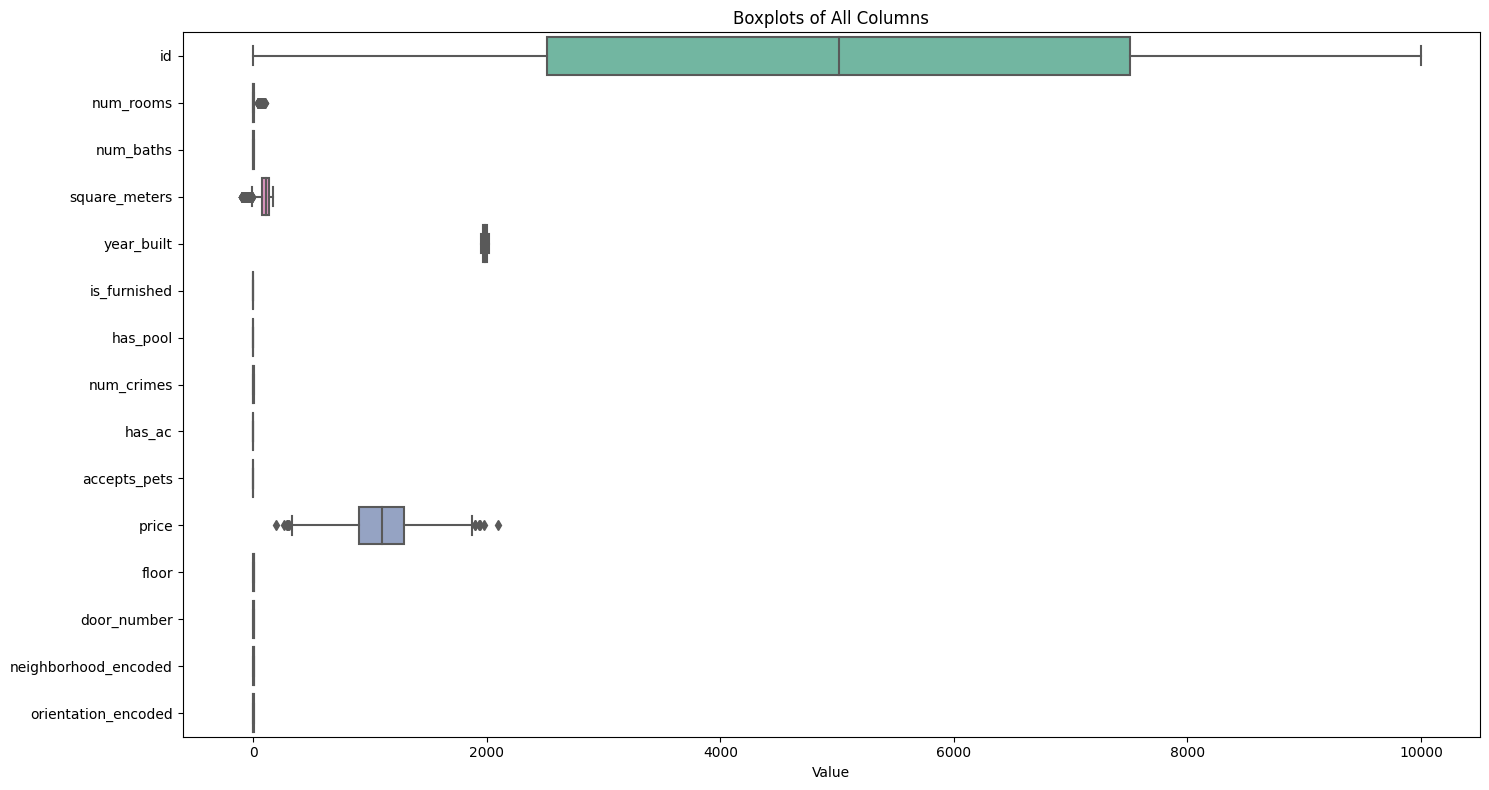

In [34]:
# detetct where outliers are 
plt.figure(figsize=(15, 8))

# Create boxplots for all columns
sns.boxplot(data=data, orient="h", palette="Set2")
plt.title("Boxplots of All Columns")
plt.xlabel("Value")

# Adjust the layout to prevent the x-axis labels from overlapping
plt.tight_layout()

# Show the plot
plt.show()

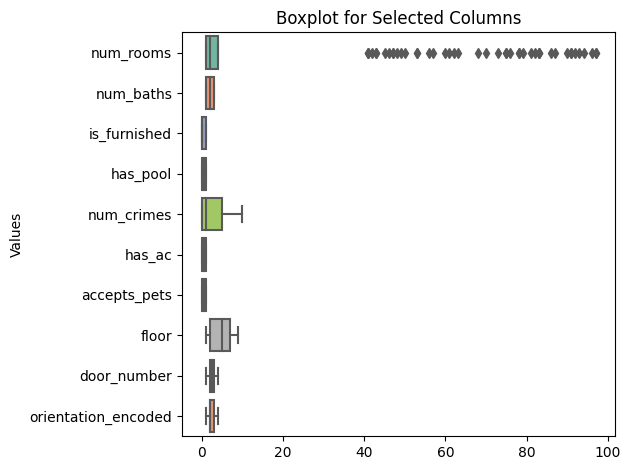

In [35]:
# Select the columns you want to include in the boxplot
selected_columns = ['num_rooms', 'num_baths', 'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets', 'floor', 'door_number', 'orientation_encoded']

# Create a boxplot for the selected columns

sns.boxplot(data=data[selected_columns], orient="h", palette="Set2")

# Customize the plot if needed
plt.title("Boxplot for Selected Columns")
plt.ylabel("Values")

# Adjust the layout to prevent the x-axis labels from overlapping
plt.tight_layout()

# Show the plot
plt.show()

<Axes: >

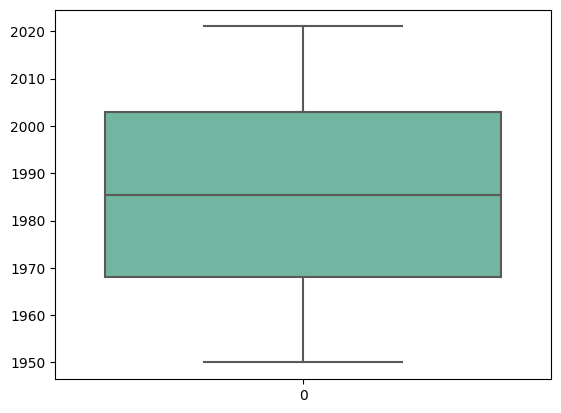

In [36]:
sns.boxplot(data=data['year_built'], palette="Set2")

In [37]:
# no outliers in these columns

<Axes: >

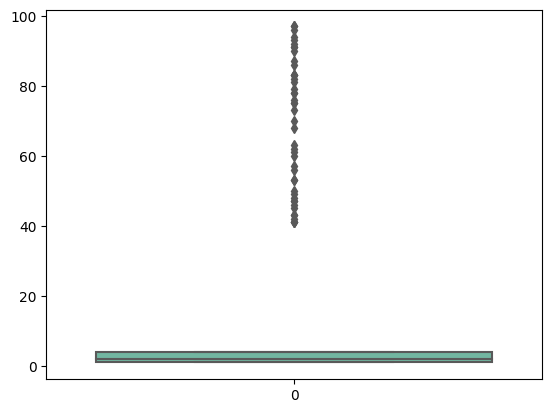

In [38]:
sns.boxplot(data=data['num_rooms'], palette="Set2")

In [39]:
data[data['num_rooms'] > 20].count()

id                      46
num_rooms               46
num_baths               46
square_meters           46
year_built              46
is_furnished            46
has_pool                46
num_crimes              46
has_ac                  46
accepts_pets            46
price                   46
floor                   46
door_number             46
neighborhood_encoded    46
orientation_encoded     46
dtype: int64

In [40]:
#46 values where num_rooms does not make sense -> delete these rows
data = data[data['num_rooms'] <= 20]

<Axes: >

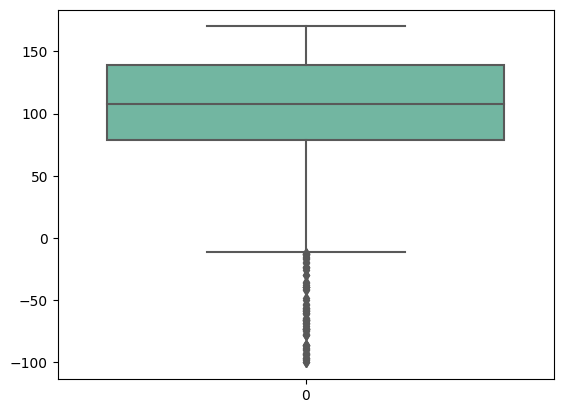

In [41]:
sns.boxplot(data=data['square_meters'], palette="Set2")

In [42]:
data[data['square_meters']<0]

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,price,floor,door_number,neighborhood_encoded,orientation_encoded
3,6088,1.0,2.000000,-41.0,2002.0,0.0,1.000000,5.0,0.0,0.000000,1290,6.0,1.0,3.673267,2
126,5226,4.0,1.000000,-15.0,1984.0,1.0,0.504207,2.0,0.0,1.000000,1093,6.0,2.0,4.488462,1
129,1053,3.0,3.000000,-97.0,2000.0,1.0,1.000000,0.0,0.0,1.000000,1352,1.0,3.0,3.076628,3
156,3729,3.0,1.000000,-78.0,2009.0,0.0,0.000000,6.0,0.0,0.507967,678,9.0,2.0,2.215190,1
169,6815,1.0,3.000000,-36.0,1966.0,1.0,0.000000,0.0,1.0,1.000000,982,2.0,3.0,0.628342,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,7344,4.0,1.988265,-68.0,1957.0,0.0,0.504207,8.0,0.0,0.000000,842,9.0,1.0,3.076628,4
7688,6103,1.0,2.000000,-72.0,1976.0,1.0,0.000000,2.0,0.0,0.000000,873,2.0,1.0,3.497333,1
7833,3305,2.0,1.000000,-11.0,1993.0,0.0,0.000000,0.0,0.0,1.000000,1343,9.0,3.0,0.921438,1
7916,5277,1.0,1.000000,-73.0,2001.0,0.0,1.000000,0.0,1.0,0.000000,1074,1.0,2.0,0.628342,1


In [43]:
data = data[data['square_meters']>0]

<Axes: >

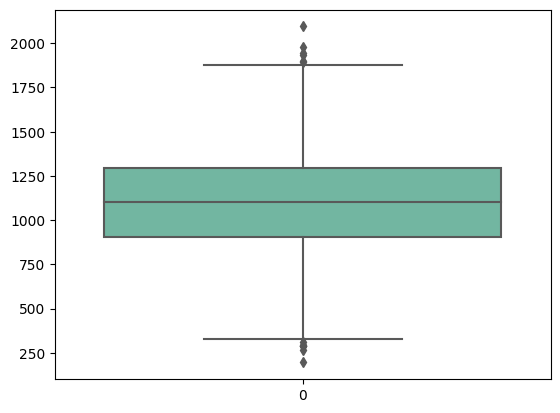

In [44]:
sns.boxplot(data=data['price'], palette="Set2")

<function matplotlib.pyplot.show(close=None, block=None)>

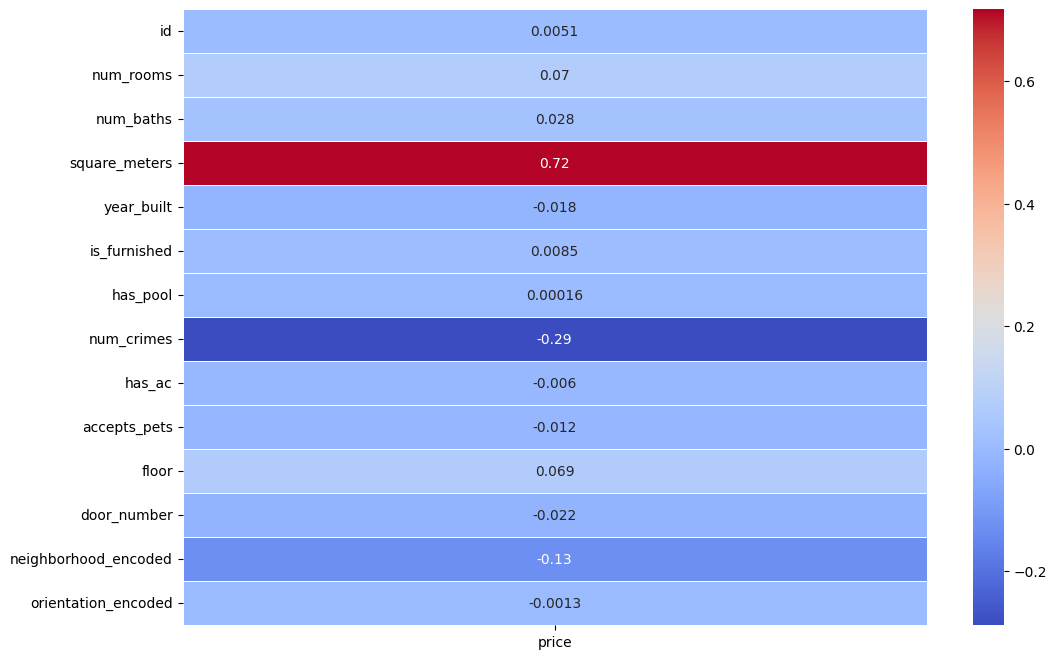

In [45]:
# Calculate the correlation matrix
correlation_matrix = data.corr(method='pearson')

# Calculate the correlation of all columns with respect to the 'price' column
price_correlation = correlation_matrix['price']

# The 'price' column will also have a correlation of 1 with itself. You can remove it if needed.
price_correlation = price_correlation.drop('price')

plt.figure(figsize=(12, 8))
sns.heatmap(price_correlation.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show

In [46]:
features = ['square_meters', 'num_crimes', 'neighborhood_encoded']
target = ['price']
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.33, random_state=42)
y_test

,price
7160,1139
514,604
6610,1004
5486,1314
2356,1499
...,...
3257,1363
7250,1139
1841,757
5068,959


In [47]:
# Create a LinearRegression model
linreg = LinearRegression()

# Fit the model to the training data
linreg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linreg.predict(X_test)

# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)

print(f"R-squared Score: {r2}")

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

R-squared Score: 0.5936497646213845
Mean Absolute Error: 137.152711805721
Mean Squared Error: 29931.79459355873


In [48]:
y_test['price_predicted'] = y_pred
y_test

,price,price_predicted
7160,1139,1289.932904
514,604,932.678770
6610,1004,1093.466404
5486,1314,1226.541955
2356,1499,1442.994531
...,...,...
3257,1363,1273.104461
7250,1139,1046.177747
1841,757,976.794280
5068,959,1250.114052
